In [1]:
import sys
import rics

# Print relevant versions
print(f"{rics.__version__=}")
print(f"{sys.version=}")
!git log --pretty=oneline --abbrev-commit -1

rics.__version__='2.0.0.dev1'
sys.version='3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]'
b8cf6bd (HEAD, origin/main, origin/HEAD, main) Split idt/cs


In [2]:
from rics import configure_stuff
import logging

configure_stuff(level=logging.INFO, rics_level=logging.DEBUG)

# Pandas GroupBy row selection
Selecting the best row per group. Best is defined as `min(df.Value)`.

## Load data
Load some representative data we need for testing (that doesn't change between test cases or candidates).

In [3]:
import pandas as pd
import numpy as np
from itertools import product

np.random.seed(1999)


def make_sample_data(size: int, num_groups: int) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "Value": np.round(1000 * np.random.random(size), 2),
            "Group": np.random.randint(num_groups, size=size),
            # Add random data to give naive methods more things to move around, for realism.
            "random floats": np.random.random(size),
            "random integers": np.random.randint(100, size=size),
            "random booleans": np.random.randint(2, size=size, dtype=bool),
            "random strings": pd._testing.rands_array(16, size=size),
        }
    )


test_data = {
    f"$10^{exp}$ rows, {num_groups} groups": make_sample_data(10**exp, num_groups)
    for exp, num_groups in product(
        [1, 3, 4, 5],
        [2, 10, 100],
    )
}

## Define candidates
All candidates will reorder the input dataframe based on the sorting order of `df.Group`.

In [4]:
def linear_search(df: pd.DataFrame) -> pd.DataFrame:
    group_iloc = {}
    group_best = {}
    for i, (group, value) in enumerate(zip(df.Group, df.Value)):
        if group not in group_best or group_best[group] > value:
            group_best[group] = value
            group_iloc[group] = i

    return df.iloc[list(group_iloc.values())]


def sort_groupby_head(df: pd.DataFrame) -> pd.DataFrame:
    return df.sort_values("Value").groupby("Group").head(1)


def sort_groupby_head_inplace(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values("Value", inplace=True)
    return df.groupby("Group").head(1)


candidates = {
    "Linear search": linear_search,
    "Sort-GroupBy-Head": sort_groupby_head,
    "Sort-GroupBy-Head\nsort inplace": sort_groupby_head_inplace,
}

## Verification
Make sure candidates are equivalent.

In [5]:
reference_data = test_data[list(test_data)[4]]
reference_output = candidates[list(candidates)[0]](reference_data).sort_index()
assert reference_output is not None
print("Reference output:")
reference_output

Reference output:


,Value,Group,random floats,random integers,random booleans,random strings
161,10.98,2,0.467889,32,False,mR9mFOqLWGCPkKUY
317,12.66,9,0.0727275,86,True,d7Lk2fLKIxe6028l
404,14.76,7,0.952243,10,True,NzJwe4eWYcKpQyaV
511,4.4,4,0.244193,15,False,oFQ4MjbeWQz9U8Pg
625,3.94,1,0.284367,87,False,vWXCLMarSxv1K7VV
675,5.8,0,0.444352,6,True,3v5hJYV70yXHmfKH
698,10.35,5,0.0454148,20,True,1m81NLTspsTUHbDF
727,7.02,3,0.172749,47,False,Fjq4BjnlBgInijej
740,9.49,8,0.217686,26,False,0ci5GG56lukI5vkC
817,6.87,6,0.268581,33,True,Yc53DpMgrGsLkwMX


In [6]:
for cand in candidates.values():
    cand_output = cand(reference_data).sort_index()
    pd.testing.assert_frame_equal(reference_output, cand_output)

## Run performance comparison
Run comparison, show results per candidate and test data set.

2022-12-10T18:43:39.488 [rics.performance:INFO] Evaluate candidate 'Linear search' 5x40 times..
2022-12-10T18:43:45.631 [rics.performance:INFO] Evaluate candidate 'Sort-GroupBy-Head' 5x26 times..
2022-12-10T18:43:48.235 [rics.performance:INFO] Evaluate candidate 'Sort-GroupBy-Head\nsort inplace' 5x50 times..


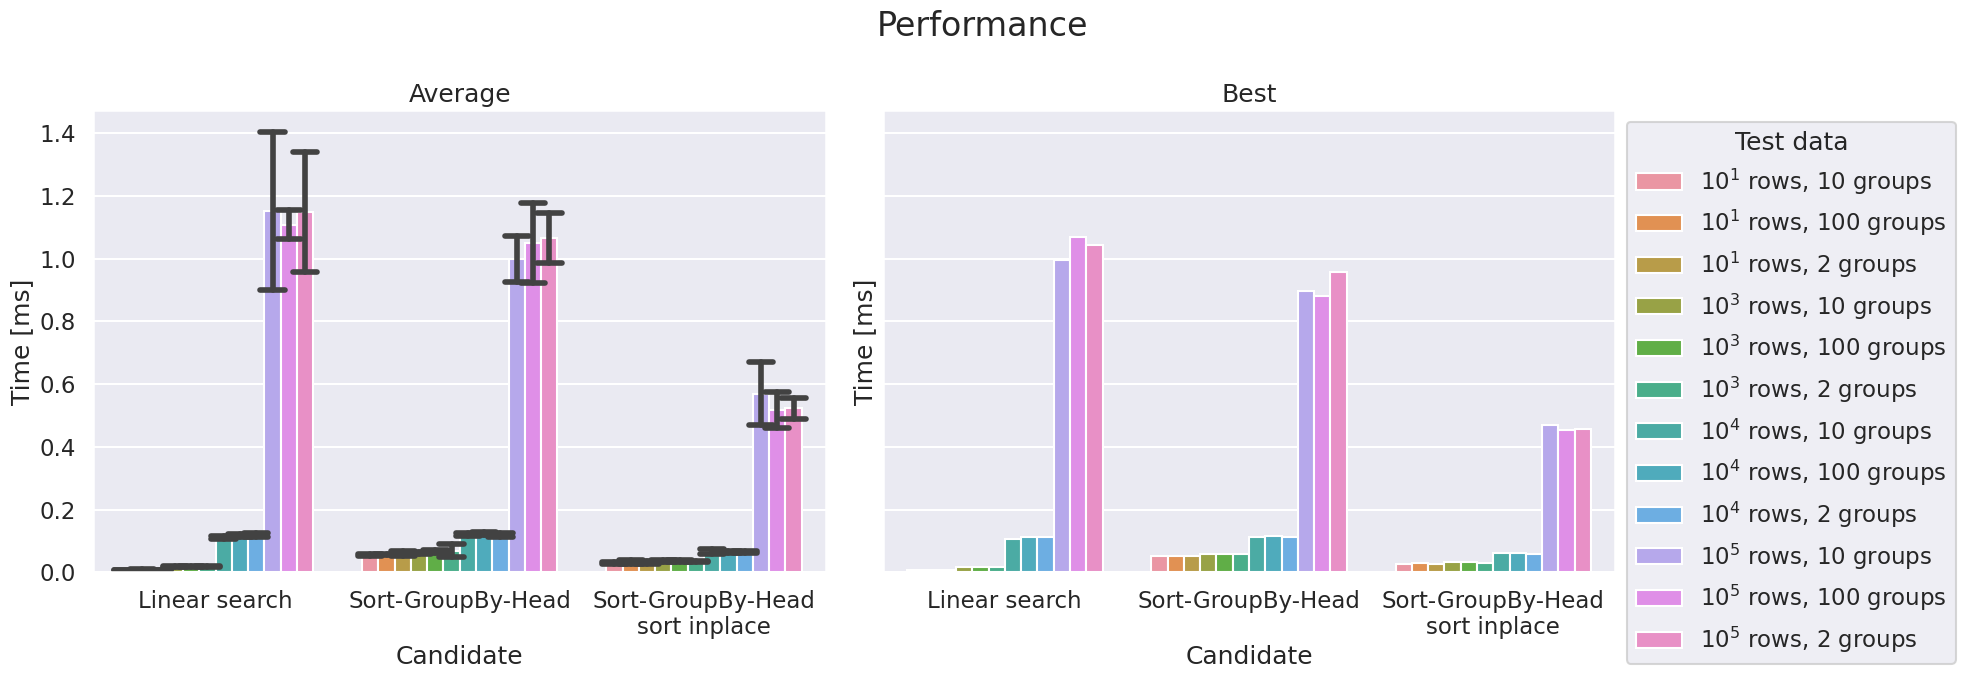

In [7]:
from rics.performance import run_multivariate_test, get_best

data = run_multivariate_test(candidates, test_data)

### Performance summary
Best choice per data label.

In [8]:
get_best(data)

,Candidate,Test data,Run no,Time [s],Time [ms],Time [μs],Times min,Times mean
13,Linear search,"$10^1$ rows, 2 groups",13,7.2121e-06,0.0072121,7.2121,1,0.239741
68,Linear search,"$10^1$ rows, 10 groups",28,7.22138e-06,0.00722138,7.22138,1,0.252988
99,Linear search,"$10^1$ rows, 100 groups",19,7.94935e-06,0.00794935,7.94935,1,0.265152
193,Linear search,"$10^3$ rows, 10 groups",33,1.69159e-05,0.0169159,16.9159,1,0.468397
143,Linear search,"$10^3$ rows, 2 groups",23,1.71852e-05,0.0171852,17.1852,1,0.466542
218,Linear search,"$10^3$ rows, 100 groups",18,1.7897e-05,0.017897,17.897,1,0.477084
1127,Sort-GroupBy-Head\nsort inplace,"$10^4$ rows, 2 groups",35,6.04779e-05,0.0604779,60.4779,1,0.631018
1166,Sort-GroupBy-Head\nsort inplace,"$10^4$ rows, 10 groups",24,6.19255e-05,0.0619255,61.9255,1,0.659864
1239,Sort-GroupBy-Head\nsort inplace,"$10^4$ rows, 100 groups",47,6.21843e-05,0.0621843,62.1843,1,0.643523
1389,Sort-GroupBy-Head\nsort inplace,"$10^5$ rows, 100 groups",47,0.000455169,0.455169,455.169,1,0.541458


# Conclusion
* Number of groups seems to have a marginal but measureable impact. 
* For larger datasets, the `Sort - Groupby - Head` methods are faster.
* Linear search is faster for small (~1000 rows) only. Just an issue of Python being slow, or does the SGH parallelize?
* Inplace sorting is significantly faster and should be preferred when possible.